In [2]:
from py2neo import Graph
from py2neo import Node

In [26]:
import pandas as pd

In [51]:
from matplotlib import pyplot as plt

In [1]:
#creates a py2neo database 
from py2neo import Database
db = Database("bolt://disease.ncats.io:80")
#the connection seems to only last for about an hour

In [2]:
#gets the graph object from databse
graph = db.default_graph

In [6]:
#alternatively, we can also get the remote db with the Graph constructer
#graph = Graph("bolt://localhost:7687") 

## Distribution of phenotype connections in GARD database

The example below gets the phenotype nodes connected to the S_GARD disease with the data id of 1. This disease is GRACILE syndrome. This runs a query using .run on the disease graph. This returns a cursor where you can print out the results of the query, as shown below. 

In [20]:
query = """match (n:S_GARD)--(d:DATA) where d.id = 1 with n, 
d match p =(n)-[:R_rel]-(s:S_HP)--(:DATA) return d.id, s.N_Name
"""

cursor = graph.run(query)

#print the records from the Database.cursor object
for record in cursor:
    print(record)

<Record d.id=1 s.N_Name=['HYPOTONIA, IN NEONATAL ONSET', 'LOW MUSCLE TONE, IN NEONATAL ONSET', 'HYPOTONIA, NEONATAL', 'CONGENITAL HYPOTONIA', 'NEONATAL HYPOTONIA']>
<Record d.id=1 s.N_Name=['INCREASED SERUM PYRUVIC ACID', 'INCREASED SERUM PYRUVATE']>
<Record d.id=1 s.N_Name='CHRONIC LACTIC ACIDOSIS'>
<Record d.id=1 s.N_Name=['AUTOSOMAL RECESSIVE', 'AUTOSOMAL RECESSIVE FORM', 'AUTOSOMAL RECESSIVE PREDISPOSITION', 'AUTOSOMAL RECESSIVE INHERITANCE']>
<Record d.id=1 s.N_Name=['HIGH FERRITIN LEVEL', 'INCREASED PLASMA FERRITIN', 'INCREASED FERRITIN', 'INCREASED SERUM FERRITIN LEVEL', 'HYPERFERRITINAEMIA', 'ELEVATED SERUM FERRITIN', 'HYPERFERRITINEMIA', 'INCREASED SERUM FERRITIN']>
<Record d.id=1 s.N_Name=['HYPERAMINOACIDURIA', 'INCREASED LEVELS OF ANIMO ACIDS IN URINE', 'HIGH URINE AMINO ACID LEVELS', 'ABNORMAL URINARY AMINO-ACID FINDINGS', 'AMINOACIDURIA']>
<Record d.id=1 s.N_Name='INCREASED SERUM IRON'>
<Record d.id=1 s.N_Name=['PRENATAL GROWTH RETARDATION', 'PRENATAL GROWTH FAILURE', 'PRE

### Getting the phenotype counts for all GARD diseases
Below is the query to get the phenotype counts for all the GARD disease. It return the data id (d.id) of the GARD node, the name property of the GARD node (n.N_Name), and the count of connected phenotypes from the S_HP database. 

The result is saved in a dictionary format, which can then create a pandas DataFrame object, to more easily investigate the data. We can then use the phenotype count column to generate a histogram to see the phenotype connection distribution across GARD. 

In [10]:
#phenotype count query
phen_query = """match (n:S_GARD)--(d:DATA)  with n, d 
            match p =(n)-[:R_rel{name:"has_phenotype"}]
            -(s:S_HP)--(:DATA) return d.id, n.N_Name, count(s)"""
phen_dict = graph.run(phen_query).data()

In [12]:
phen_df = pd.DataFrame.from_dict(phen_dict)
phen_df.head()

,d.id,n.N_Name,count(s)
0,1,"[GRACILE SYNDROME, FLNMS, FINNISH LACTIC ACIDO...",16
1,3,"[ABLEPHARON MACROSTOMIA SYNDROME, AMS, CONGENI...",49
2,5,"[ABETALIPOPROTEINEMIA, BASSEN KORNZWEIG SYNDRO...",14
3,7,"[ACROMICRIC DYSPLASIA, ACROMICRIC SKELETAL DYS...",29
4,11,"[ALTERNATING HEMIPLEGIA OF CHILDHOOD, ALTERNAT...",9
5,13,"[GILLESPIE SYNDROME, ANIRIDIA, CEREBELLAR ATAX...",19
6,19,"[DIHYDROPYRIMIDINE DEHYDROGENASE DEFICIENCY, D...",23
7,22,"[BJORNSTAD SYNDROME, BJS, PILI TORTI AND NERVE...",12
8,23,[BLEPHAROPHIMOSIS-EPICANTHUS INVERSUS-PTOSIS S...,21
9,28,"[CATEL MANZKE SYNDROME, HYPERPHALANGY-CLINODAC...",24


In [57]:
phen_df.shape

(2254, 4)

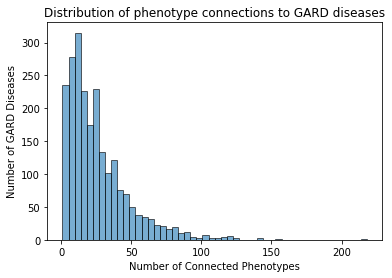

In [55]:
plt.hist(phen_df["count(s)"], bins=50, alpha = 0.6, ec = "black")
plt.xlabel("Number of Connected Phenotypes")
plt.ylabel("Number of GARD Diseases")
plt.title("Distribution of phenotype connections to GARD diseases")
plt.show()

The graph above shows how the majority of GARD diseases have about less than 25 connections to phenotype nodes from the HP datasource. As the number of connected phenotypes increase, the number of GARD nodes decreases. 

It should also be noted that the number of GARD diseases represented here is 2254. However the total number of diseases is 6232. This means that there are 3978 diseases that do have 0 connections to a an HP phenotype node. 

In [31]:
#important to save- or else we'll need to run the query again after shutting down the notebook 
phen_df.to_csv("GARD_Phenotype_Distribution.csv")

In [50]:
#reading in the csv to use 
phen_df = pd.read_csv("GARD_Phenotype_Distribution.csv")

### Power law analysis for GARD to phenotype distribution 

Looking at the phenotype distribution histogram, it may be possible to represent the proportion of of GARD nodes to the number of phenotype connections as a power law function. A power law function decreases with the number of connections by some set power, approximately $ 1/k^{c} $ where k is the number of connections and s is the set power. 

We can check if the distribution represents a power law function by taking the log of the y-axis. This is because $ f(k) = 1/k^{c} $ can be represented as $log f(k) = log(a) − c (log(k))$. The graph of this relationship should then appear to be a straight line. 

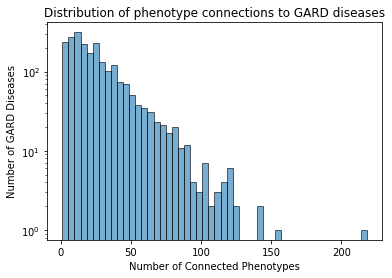

In [63]:
plt.hist(phen_df["count(s)"], bins=50, alpha = 0.6, ec = "black", log = True)
plt.xlabel("Number of Connected Phenotypes")
plt.ylabel("Number of GARD Diseases")
plt.title("Distribution of phenotype connections to GARD diseases")
plt.show()

Looking at the log version of the graph, it does indeed approximately follow a power law function. 

## Distribution of GARD connections to phenotypes

This distribution follows the one above, but is flipped. Instead of looking at the phenotype connections to a disease, we will observe the disease connections to a phenotype. We do this by returning the phenotype variables of the query and the count of the GARD nodes. The rest of the code is as normal.  

In [24]:
%%time
#want to check how long the query will take in the notebook
#getting the count of diseases connected to phenotype nodes 
flip_phen_query = """match (n:S_HP)--(d:DATA) with n, d 
                    match p =(n)-[:R_rel{name:"has_phenotype"}]-(s:S_GARD) 
                    return d.id, n.N_Name, count(s)"""
flip_phen_dict = graph.run(flip_phen_query).data()

CPU times: user 190 ms, sys: 49.3 ms, total: 239 ms
Wall time: 5min 50s


In [28]:
flip_phen_df = pd.DataFrame.from_dict(flip_phen_dict)
flip_phen_df.head(10)

,d.id,n.N_Name,count(s)
0,HP:0001994,"[RENAL TUBULAR FANCONI SYNDROME, 'DE TONI-FANC...",5
1,HP:0001394,"[HEPATIC CIRRHOSIS, SCAR TISSUE REPLACES HEALT...",48
2,HP:0000365,"[HEARING DEFECT, CONGENITAL DEAFNESS, HEARING ...",207
3,HP:0003128,"[LACTICACIDOSIS, LACTICACIDEMIA, HYPERLACTICAC...",43
4,HP:0012465,"[INCREASED IRON CONCENTRATION IN LIVER, INCREA...",2
5,HP:0001397,"[LIVER STEATOSIS, FATTY LIVER, FATTY INFILTRAT...",45
6,HP:0100613,[DEATH IN EARLY ADULTHOOD],10
7,HP:0012464,DECREASED TRANSFERRIN SATURATION,1
8,HP:0004925,CHRONIC LACTIC ACIDOSIS,3
9,HP:0003452,INCREASED SERUM IRON,5


In [34]:
flip_phen_df.sort_values(by="count(s)", ascending=False)

,d.id,n.N_Name,count(s)
18,HP:0000007,"[AUTOSOMAL RECESSIVE, AUTOSOMAL RECESSIVE FORM...",1048
17,HP:0000006,"[AUTOSOMAL DOMINANT, AUTOSOMAL DOMINANT TYPE, ...",844
127,HP:0001250,"[SEIZURE, SEIZURES, EPILEPSY]",531
103,HP:0001249,"[INTELLECTUAL DISABILITY, NONPROGRESSIVE INTEL...",531
53,HP:0001263,"[RETARDED DEVELOPMENT, LACK OF PSYCHOMOTOR DEV...",452
...,...,...,...
4639,HP:0007546,LINEAR HYPERPIGMENTATION,1
4638,HP:0006638,"[MISSING MIDDLE PART OF COLLARBONE, MIDCLAVICU...",1
4637,HP:0011847,GIANT CELL TUMOR OF BONE,1
4636,HP:0011599,MESOCARDIA,1


In [30]:
#saving into a csv file
flip_phen_df.to_csv("Phenotype_GARD_Distribution.csv")

In [64]:
flip_phen_df = pd.read_csv("Phenotype_GARD_Distribution.csv")

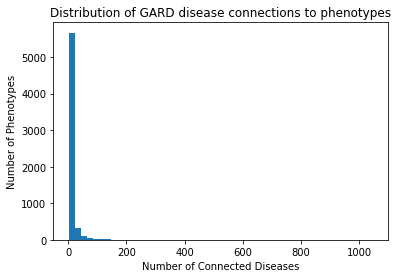

In [69]:
plt.hist(flip_phen_df["count(s)"], bins=50)
plt.xlabel("Number of Connected Diseases")
plt.ylabel("Number of Phenotypes")
plt.title("Distribution of GARD disease connections to phenotypes")
plt.show()

This histogram is far more extreme than the previous. Out of the 6251 HP phenotype nodes, nearly all of them have less than 100 connected diseases. The range of the graph actually extends to 1000. This is because there are a very small amount of phenotypes with up to 1000+ connections. This is reflected in the actual data, given in the dataframe output above this. Organizing by the number of connected diseases, we see that 1048 GARD disease nodes have the phenotype  "autosomal recessive." Most phenotypes, may only have 1 or a few GARD diseases they are related to, which you see at the bottom of the table. 

### Power law analysis for phenotype to GARD distribution

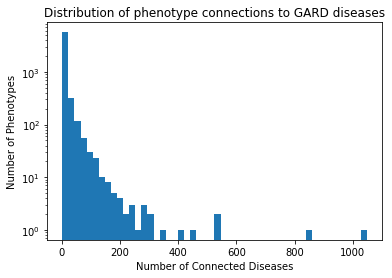

In [70]:
plt.hist(flip_phen_df["count(s)"], bins=50, log=True)
plt.xlabel("Number of Connected Diseases")
plt.ylabel("Number of Phenotypes")
plt.title("Distribution of phenotype connections to GARD diseases")
plt.show()

Looking at the log graph here, the approximation to a power law function is not at close, but slightly recognizable in the center of the data.

In [42]:
#list of the ontologies as their node label
otlgs = ["S_BTO","S_CHEBI","S_CL","S_CLINVAR","S_CLO","S_DDIEM","S_DOID","S_EFO","S_FDAORPHANGARD_20190216","S_FMA"
         ,"S_GARD","S_GENO","S_GHR","S_GO","S_HPO_ANNOTATION_100918","S_ICD10CM","S_MEDGEN","S_MEDLINEPLUS"
         ,"S_MESH","S_MONDO","S_MP","S_NORD","S_OAE","S_OGG","S_OMIM","S_ORDO_ORPHANET","S_PATO","S_PW"
         ,"S_RANCHO-DISEASE-DRUG_2018-12-18_13-30","S_RXNO","S_THESAURUS","S_UBERON","S_VANDF"]

In [49]:
#create a function to execute this distribution query for the other databases
def phenotype_dist(onto_name, make_csv=True, output=True):
    query = f"""match (n:{onto_name})--(d:DATA)  with n, d 
            match p =(n)-[:R_rel{{name:"has_phenotype"}}]
            -(s:S_HP) return d.id, n.N_Name, count(s)"""
    dictionary = graph.run(query).data()
    df = pd.DataFrame.from_dict(dictionary)
    if make_csv:
        df.to_csv(f"{onto_name}_Phenotype_Distribution.csv")
    if output:
        print(f"{onto_name} distribution done.")
    return df